In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Load data
df = pd.read_csv("daftar-harga-rumah-jabodetabek.csv")

df.head()

,url,price_in_rp,title,address,district,city,lat,long,facilities,property_type,...,electricity,maid_bedrooms,maid_bathrooms,floors,building_age,year_built,property_condition,building_orientation,garages,furnishing
0,https://www.rumah123.com/properti/bekasi/hos11...,2.990000e+09,Rumah cantik Sumarecon Bekasi\nLingkungan asri...,"Summarecon Bekasi, Bekasi",Summarecon Bekasi,Bekasi,-6.223945,106.986275,"Tempat Jemuran, Jalur Telepon, Taman, Taman",rumah,...,4400 mah,0.0,1.0,2.0,5.0,2017.0,bagus,NaN,0.0,unfurnished
1,https://www.rumah123.com/properti/bekasi/hos10...,1.270000e+09,"Rumah Kekinian, Magenta Summarecon Bekasi","Summarecon Bekasi, Bekasi",Summarecon Bekasi,Bekasi,-6.223945,106.986275,Taman,rumah,...,2200 mah,0.0,0.0,2.0,NaN,NaN,bagus,NaN,0.0,NaN
2,https://www.rumah123.com/properti/bekasi/hos10...,1.950000e+09,Rumah Cantik 2 Lantai Cluster Bluebell Summare...,"Summarecon Bekasi, Bekasi",Summarecon Bekasi,Bekasi,-6.223945,106.986275,"Jogging Track, Kolam Renang, Masjid, Taman,...",rumah,...,2200 mah,1.0,1.0,2.0,NaN,NaN,bagus,NaN,1.0,unfurnished
3,https://www.rumah123.com/properti/bekasi/hos10...,3.300000e+09,Rumah Mewah 2Lantai L10x18 C di Cluster VERNON...,"Summarecon Bekasi, Bekasi",Summarecon Bekasi,Bekasi,-6.223945,106.986275,"Jalur Telepon, Jogging Track, Track Lari, K...",rumah,...,3500 mah,1.0,1.0,2.0,6.0,2016.0,bagus sekali,utara,2.0,unfurnished
4,https://www.rumah123.com/properti/bekasi/hos10...,4.500000e+09,"Rumah Hoek di Cluster Maple Summarecon Bekasi,...","Summarecon Bekasi, Bekasi",Summarecon Bekasi,Bekasi,-6.223945,106.986275,"Jogging Track, Kolam Renang, Taman, Jalur Te...",rumah,...,3500 mah,1.0,1.0,2.0,9.0,2013.0,bagus,utara,1.0,unfurnished


In [3]:
# wrong_furnishing = ['semi furnished', 'unfurnished']
# wrong_condition = df['property_condition'].isin(wrong_furnishing)

# # Pindahkan ke furnishing jika kosong
# df.loc[wrong_condition & df['furnishing'].isna(), 'furnishing'] = df.loc[wrong_condition, 'property_condition']
# df.loc[wrong_condition, 'property_condition'] = np.nan

# # Tangani nilai 'baru' di furnishing -> harusnya di property_condition
# wrong_furnishing = df['furnishing'] == 'baru'
# df.loc[wrong_furnishing & df['property_condition'].isna(), 'property_condition'] = 'baru'
# df.loc[wrong_furnishing, 'furnishing'] = np.nan

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3553 entries, 0 to 3552
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   url                   3553 non-null   object 
 1   price_in_rp           3553 non-null   float64
 2   title                 3553 non-null   object 
 3   address               3553 non-null   object 
 4   district              3553 non-null   object 
 5   city                  3553 non-null   object 
 6   lat                   3553 non-null   float64
 7   long                  3553 non-null   float64
 8   facilities            3553 non-null   object 
 9   property_type         3552 non-null   object 
 10  ads_id                3549 non-null   object 
 11  bedrooms              3519 non-null   float64
 12  bathrooms             3524 non-null   float64
 13  land_size_m2          3551 non-null   float64
 14  building_size_m2      3551 non-null   float64
 15  carports             

In [5]:
# Gabungkan kolom bedrooms dan maid_bedrooms
df['bedrooms'] = df['bedrooms'] + df['maid_bedrooms']
df = df.drop(columns=['maid_bedrooms'])

# Gabungkan kolom bathrooms dan maid_bathrooms
df['bathrooms'] = df['bathrooms'] + df['maid_bathrooms']
df = df.drop(columns=['maid_bathrooms'])

In [6]:
# Hapus kolom yg tidak relevan
drop_cols = ["url", "title", "address", "ads_id"]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

In [7]:
# Cek missing value
missing_value = df.isnull().mean()
missing_value


price_in_rp             0.000000
district                0.000000
city                    0.000000
lat                     0.000000
long                    0.000000
facilities              0.000000
property_type           0.000281
bedrooms                0.009569
bathrooms               0.008162
land_size_m2            0.000563
building_size_m2        0.000563
carports                0.000000
certificate             0.039685
electricity             0.000000
floors                  0.001689
building_age            0.406699
year_built              0.406699
property_condition      0.069237
building_orientation    0.463552
garages                 0.000000
furnishing              0.108922
dtype: float64

In [8]:
# Karena miss value tdk terlalu tinggi (tdk mencapai 80%), maka perlu mengisi missing value
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('price_in_rp')
categorical_cols = df.select_dtypes(include=['object']).columns

for col in numerical_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

for col in categorical_cols:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)

In [9]:
# Hapus outlier
for col in numerical_cols:
    q99 = df[col].quantile(0.99)
    df = df[df[col] <= q99]

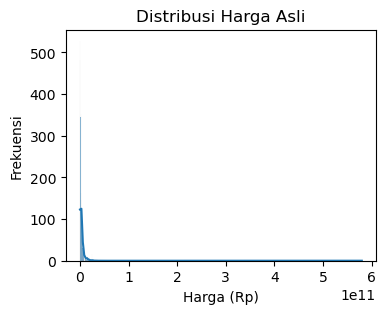

Skewness: 44.97353101021652


In [10]:
# Lihat data skewed/tidak
plt.figure(figsize=(4, 3))
sns.histplot(df["price_in_rp"], kde=True)
plt.title("Distribusi Harga Asli")
plt.xlabel("Harga (Rp)")
plt.ylabel("Frekuensi")
plt.show()

skew_value = df["price_in_rp"].skew()
print("Skewness:", skew_value)

In [11]:
# Menggunakan log supaya tidak terlalu skew
df['log_price'] = np.log(df['price_in_rp'])

In [12]:
print(df["log_price"].skew())

0.45794851664952246


Fitur numerik dengan korelasi > 0.3 terhadap log_price:
building_size_m2    0.816643
bathrooms           0.805961
bedrooms            0.758779
land_size_m2        0.696980
floors              0.531719
price_in_rp         0.398886
carports            0.324314
Name: log_price, dtype: float64


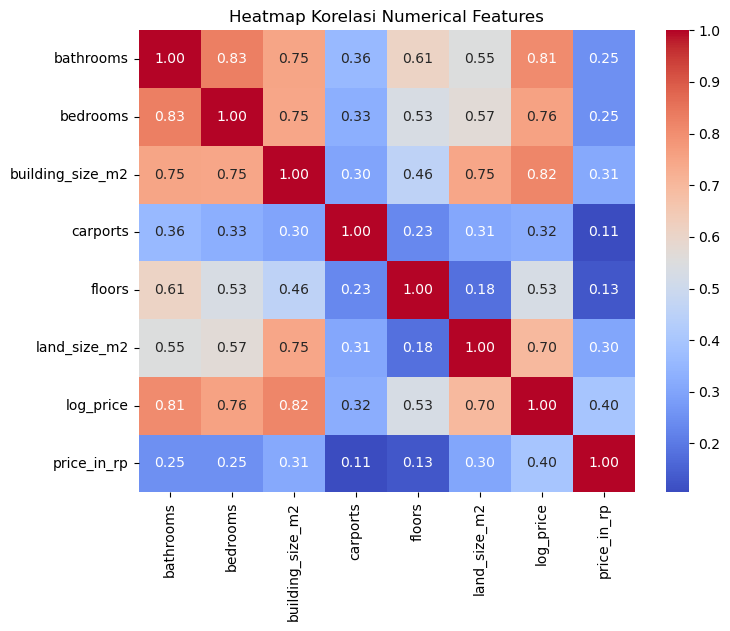

In [13]:
numerical_cols = df.select_dtypes(include=['float64']).columns.tolist()

# Hitung korelasi antar fitur numerik
corr_matrix = df[numerical_cols].corr()

# Korelasi fitur terhadap target log_price
corr_target = corr_matrix['log_price'].drop('log_price')

# Tampilkan fitur dengan korelasi absolut > 0.3
selected_features = corr_target[abs(corr_target) > 0.3].sort_values(ascending=False)
print("Fitur numerik dengan korelasi > 0.3 terhadap log_price:")
print(selected_features)

# Visualisasi heatmap korelasi fitur vs target
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix.loc[selected_features.index.union(['log_price']), selected_features.index.union(['log_price'])],
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap Korelasi Numerical Features")
plt.show()

In [14]:
# df["property_condition"] = df["property_condition"].str.lower().str.strip()

# # Mapping urutan kondisi properti ke angka (semakin bagus, semakin besar)
# condition_order = {
#     "butuh renovasi": 0,
#     "sudah renovasi": 1,
#     "bagus": 2,
#     "bagus sekali": 3,
#     "baru": 4
# }

# # Map ke angka
# df["property_condition"] = df["property_condition"].map(condition_order)

In [15]:
num_cols = ["land_size_m2", "building_size_m2", "bedrooms", "bathrooms", "floors", "carports"]
cat_onehot = ['city']
cat_target = ['district']
cat_cols = cat_onehot + cat_target

In [16]:
# Model - Linear Regression
# Buat preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("city_enc", OneHotEncoder(handle_unknown='ignore'), cat_onehot),
        ("district_enc", TargetEncoder(), cat_target),
    ])

# Buat pipeline model
model = Pipeline(steps=[
    ("prep", preprocessor),
    ("linreg", LinearRegression())
])

In [17]:
# Train/test split
X = df[cat_cols + num_cols]
y = df["log_price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
model.fit(X_train, y_train)

,steps,"[('prep', ...), ('linreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('city_enc', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [19]:
y_pred_log = model.predict(X_test)

r2_log = r2_score(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
mae_log = mean_absolute_error(y_test, y_pred_log)

print(f"R² (log scale)   : {r2_log:.4f}")
print(f"RMSE (log scale) : {rmse_log:.4f}")
print(f"MAE (log scale)  : {mae_log:.4f}")

R² (log scale)   : 0.8569
RMSE (log scale) : 0.3870
MAE (log scale)  : 0.2861


R²    : 0.1470
RMSE  : 4113404898.7956
MAE   : 1046296914.9926


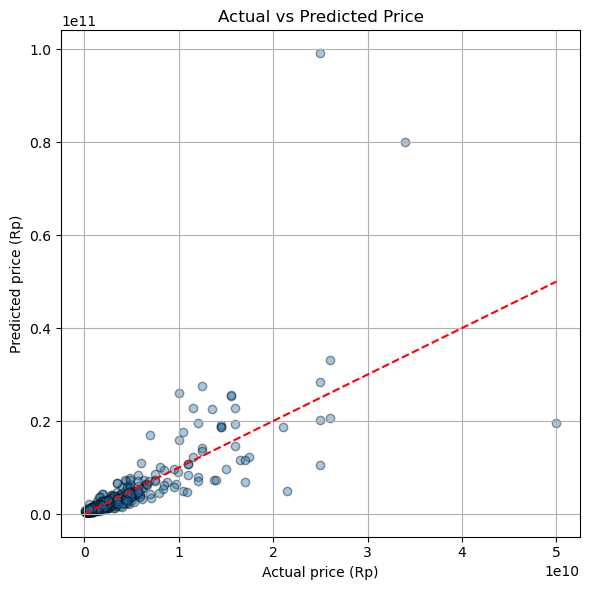

In [20]:
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"R²    : {r2:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"MAE   : {mae:.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.4, edgecolor='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('Actual price (Rp)')
plt.ylabel('Predicted price (Rp)')
plt.title('Actual vs Predicted Price')
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
def estimate_price(sample_dict):
    df_sample = pd.DataFrame([sample_dict])
    log_pred = model.predict(df_sample)[0]
    price_pred = np.expm1(log_pred)
    return price_pred

sample_house = {
    'land_size_m2': 120,
    'building_size_m2': 90,
    'bedrooms': 1,
    'bathrooms': 2,
    'floors': 2,
    'city': 'Jakarta Selatan',
    'district': 'Pondok Indah',
    'carports': 1
}

print('Estimated price (Rp):', f"{estimate_price(sample_house):,.0f}")

Estimated price (Rp): 1,328,488,749


In [22]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Fungsi dropdown umum
def _dropdown(col, label=None, options=None):
    if options is None:
        options = sorted(df[col].dropna().unique().tolist())
    return widgets.Dropdown(
        options=options,
        description=(label or col.capitalize()) + ":",
        style={'description_width': '140px'},
        layout=widgets.Layout(width="350px")
    )

# Static input
land_size  = widgets.IntText(value=120, description="Land (m²):", style={'description_width': '140px'})
build_size = widgets.IntText(value=90,  description="Building (m²):", style={'description_width': '140px'})
bedrooms   = widgets.IntSlider(value=3, min=1, max=10, description="Bedrooms:", style={'description_width': '140px'})
bathrooms  = widgets.IntSlider(value=2, min=1, max=10, description="Bathrooms:", style={'description_width': '140px'})
floors     = widgets.IntSlider(value=1, min=1, max=5,  description="Floors:", style={'description_width': '140px'})
carports     = widgets.IntSlider(value=1, min=1, max=5,  description="Carports:", style={'description_width': '140px'})

# Dropdowns
city_dd     = _dropdown("city", "City")
district_dd = _dropdown("district", "District", options=[])

# Update district dropdown saat city berubah
def update_district_options(change):
    selected_city = change['new']
    options = sorted(df[df["city"] == selected_city]["district"].dropna().unique().tolist())
    district_dd.options = options
    if options:
        district_dd.value = options[0]

city_dd.observe(update_district_options, names='value')
update_district_options({'new': city_dd.value})

# Button & output
estimate_btn = widgets.Button(description="Estimate 💰", button_style="success")
output_box   = widgets.Output()

# Aksi saat tombol diklik
def on_estimate_clicked(_):
    with output_box:
        clear_output()
        features = {
            "land_size_m2": land_size.value,
            "building_size_m2": build_size.value,
            "bedrooms": bedrooms.value,
            "bathrooms": bathrooms.value,
            "floors": floors.value,
            "carports": carports.value,
            "city": city_dd.value,
            "district": district_dd.value

        }
        log_pred = model.predict(pd.DataFrame([features]))[0]
        price_pred = np.expm1(log_pred)
        print(f"💡 Estimated price: Rp {price_pred:,.0f}")

estimate_btn.on_click(on_estimate_clicked)

# Layout form
form = widgets.VBox([
    land_size, build_size, bedrooms, bathrooms, floors, carports,
    city_dd, district_dd,
    estimate_btn
])

# Tampilkan UI
display(form, output_box)

Output()

In [23]:
import pickle
with open("model_linreg.pkl", "wb") as f:
    pickle.dump(model, f)